# Employment Scam Aegean Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(30,30)})
%reload_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("fake_job_postings.csv",index_col='job_id')
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

In [3]:
for i, header in enumerate(df.columns,start=1):
    print(f'{i}. {header}')

1. title
2. location
3. department
4. salary_range
5. company_profile
6. description
7. requirements
8. benefits
9. telecommuting
10. has_company_logo
11. has_questions
12. employment_type
13. required_experience
14. required_education
15. industry
16. function
17. fraudulent


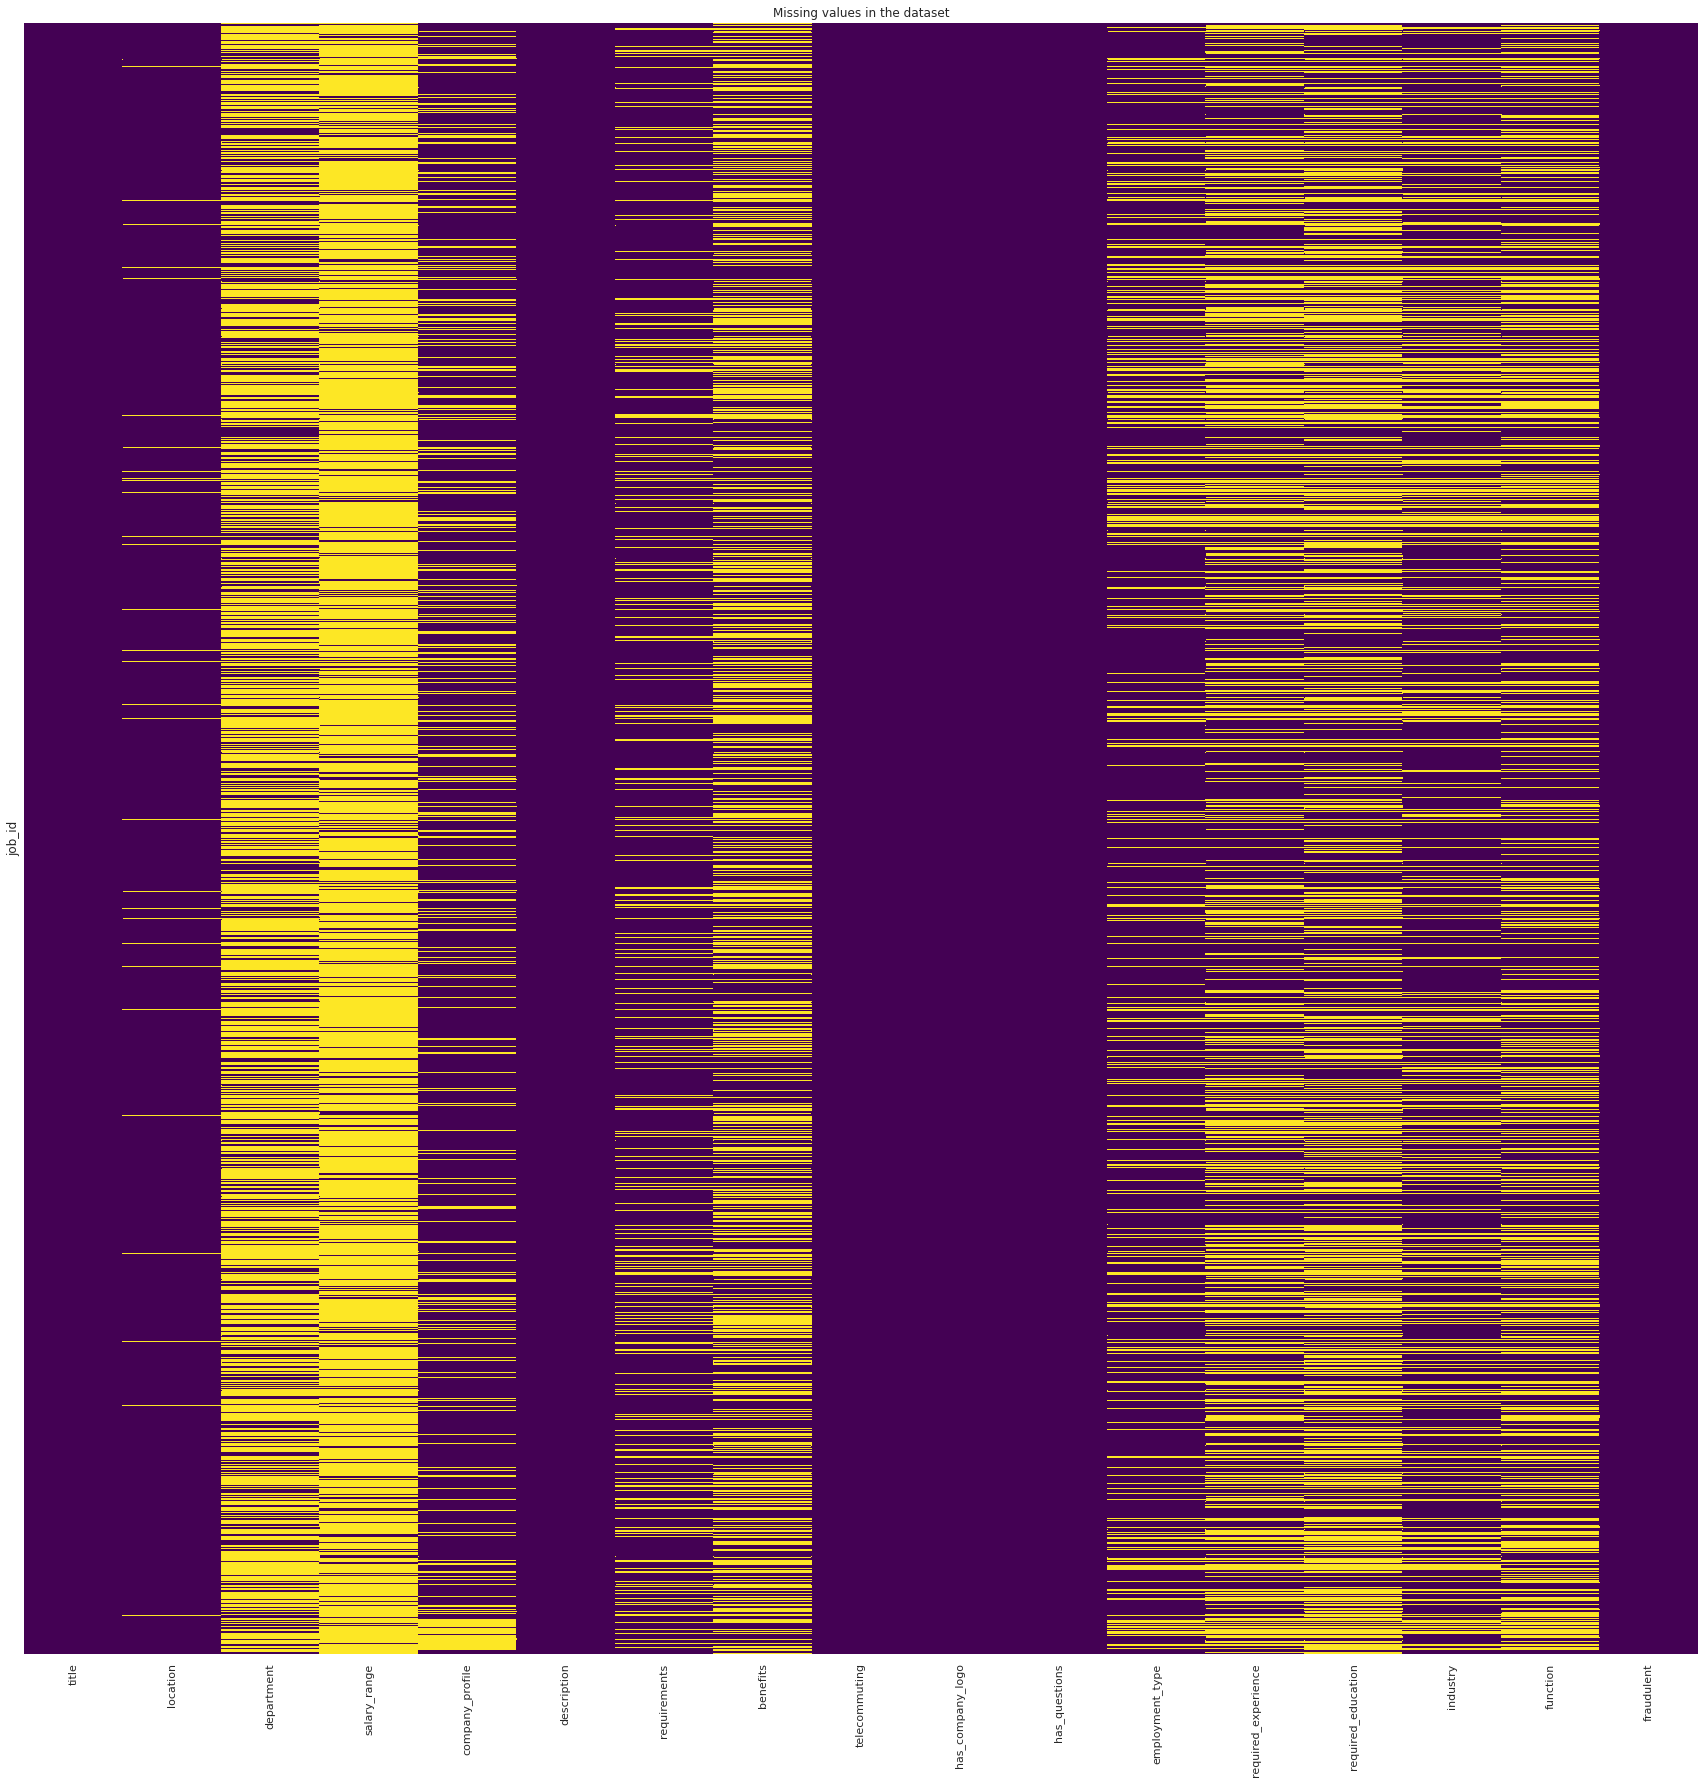

In [4]:
sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = 'viridis',);
plt.title('Missing values in the dataset');

17014


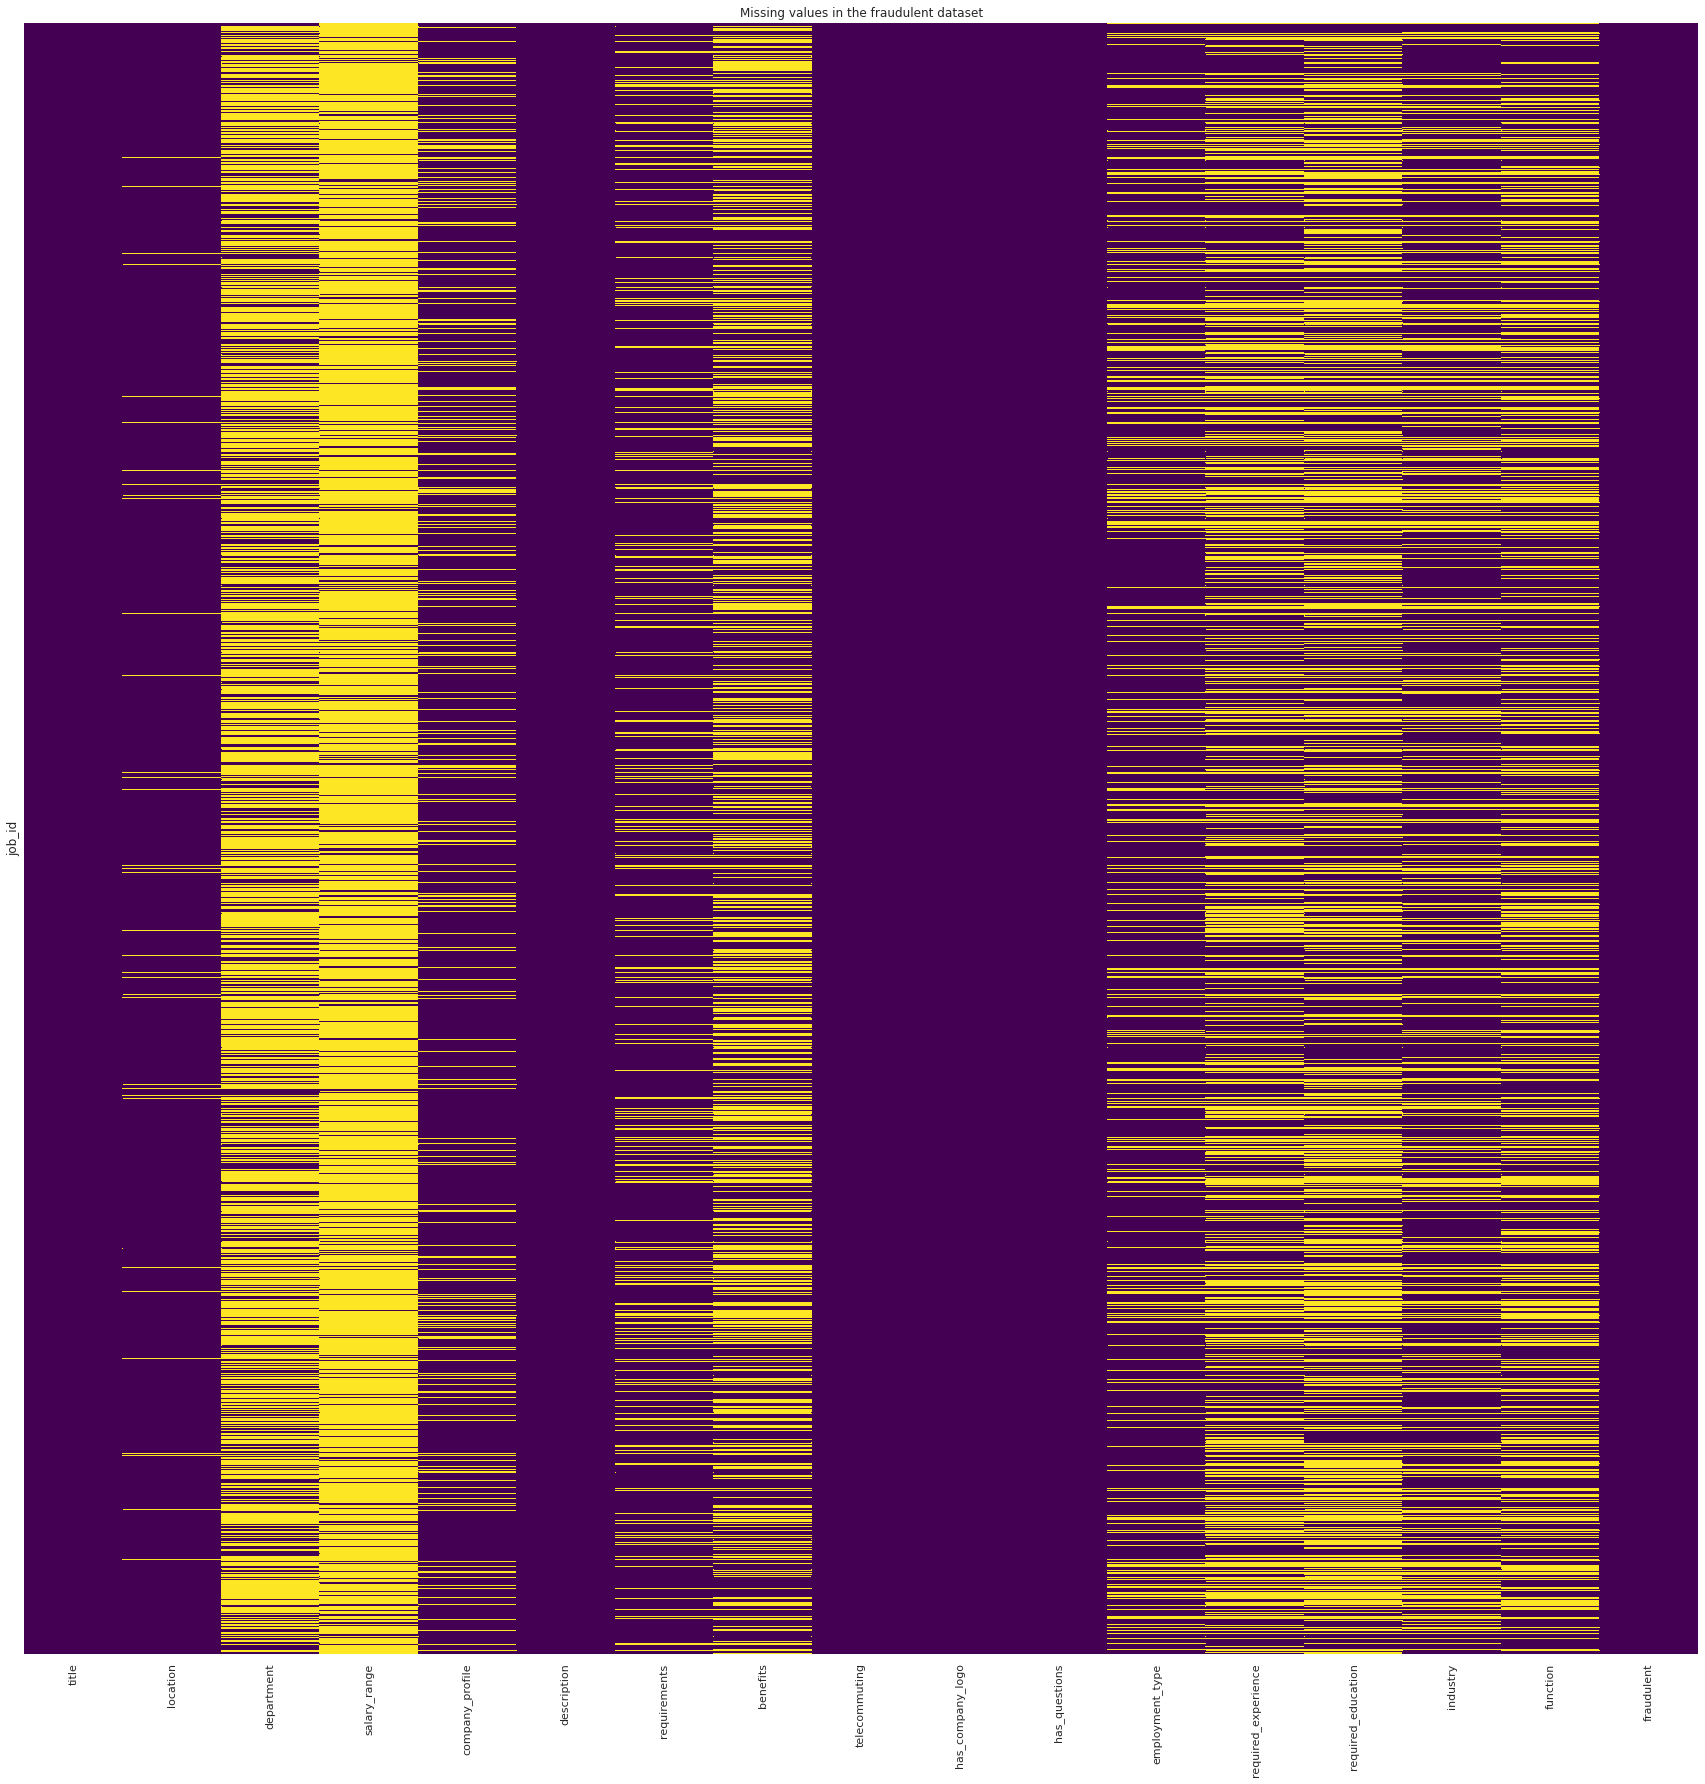

In [5]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar = False, cmap = 'viridis',);
plt.title('Missing values in the fraudulent dataset');

866


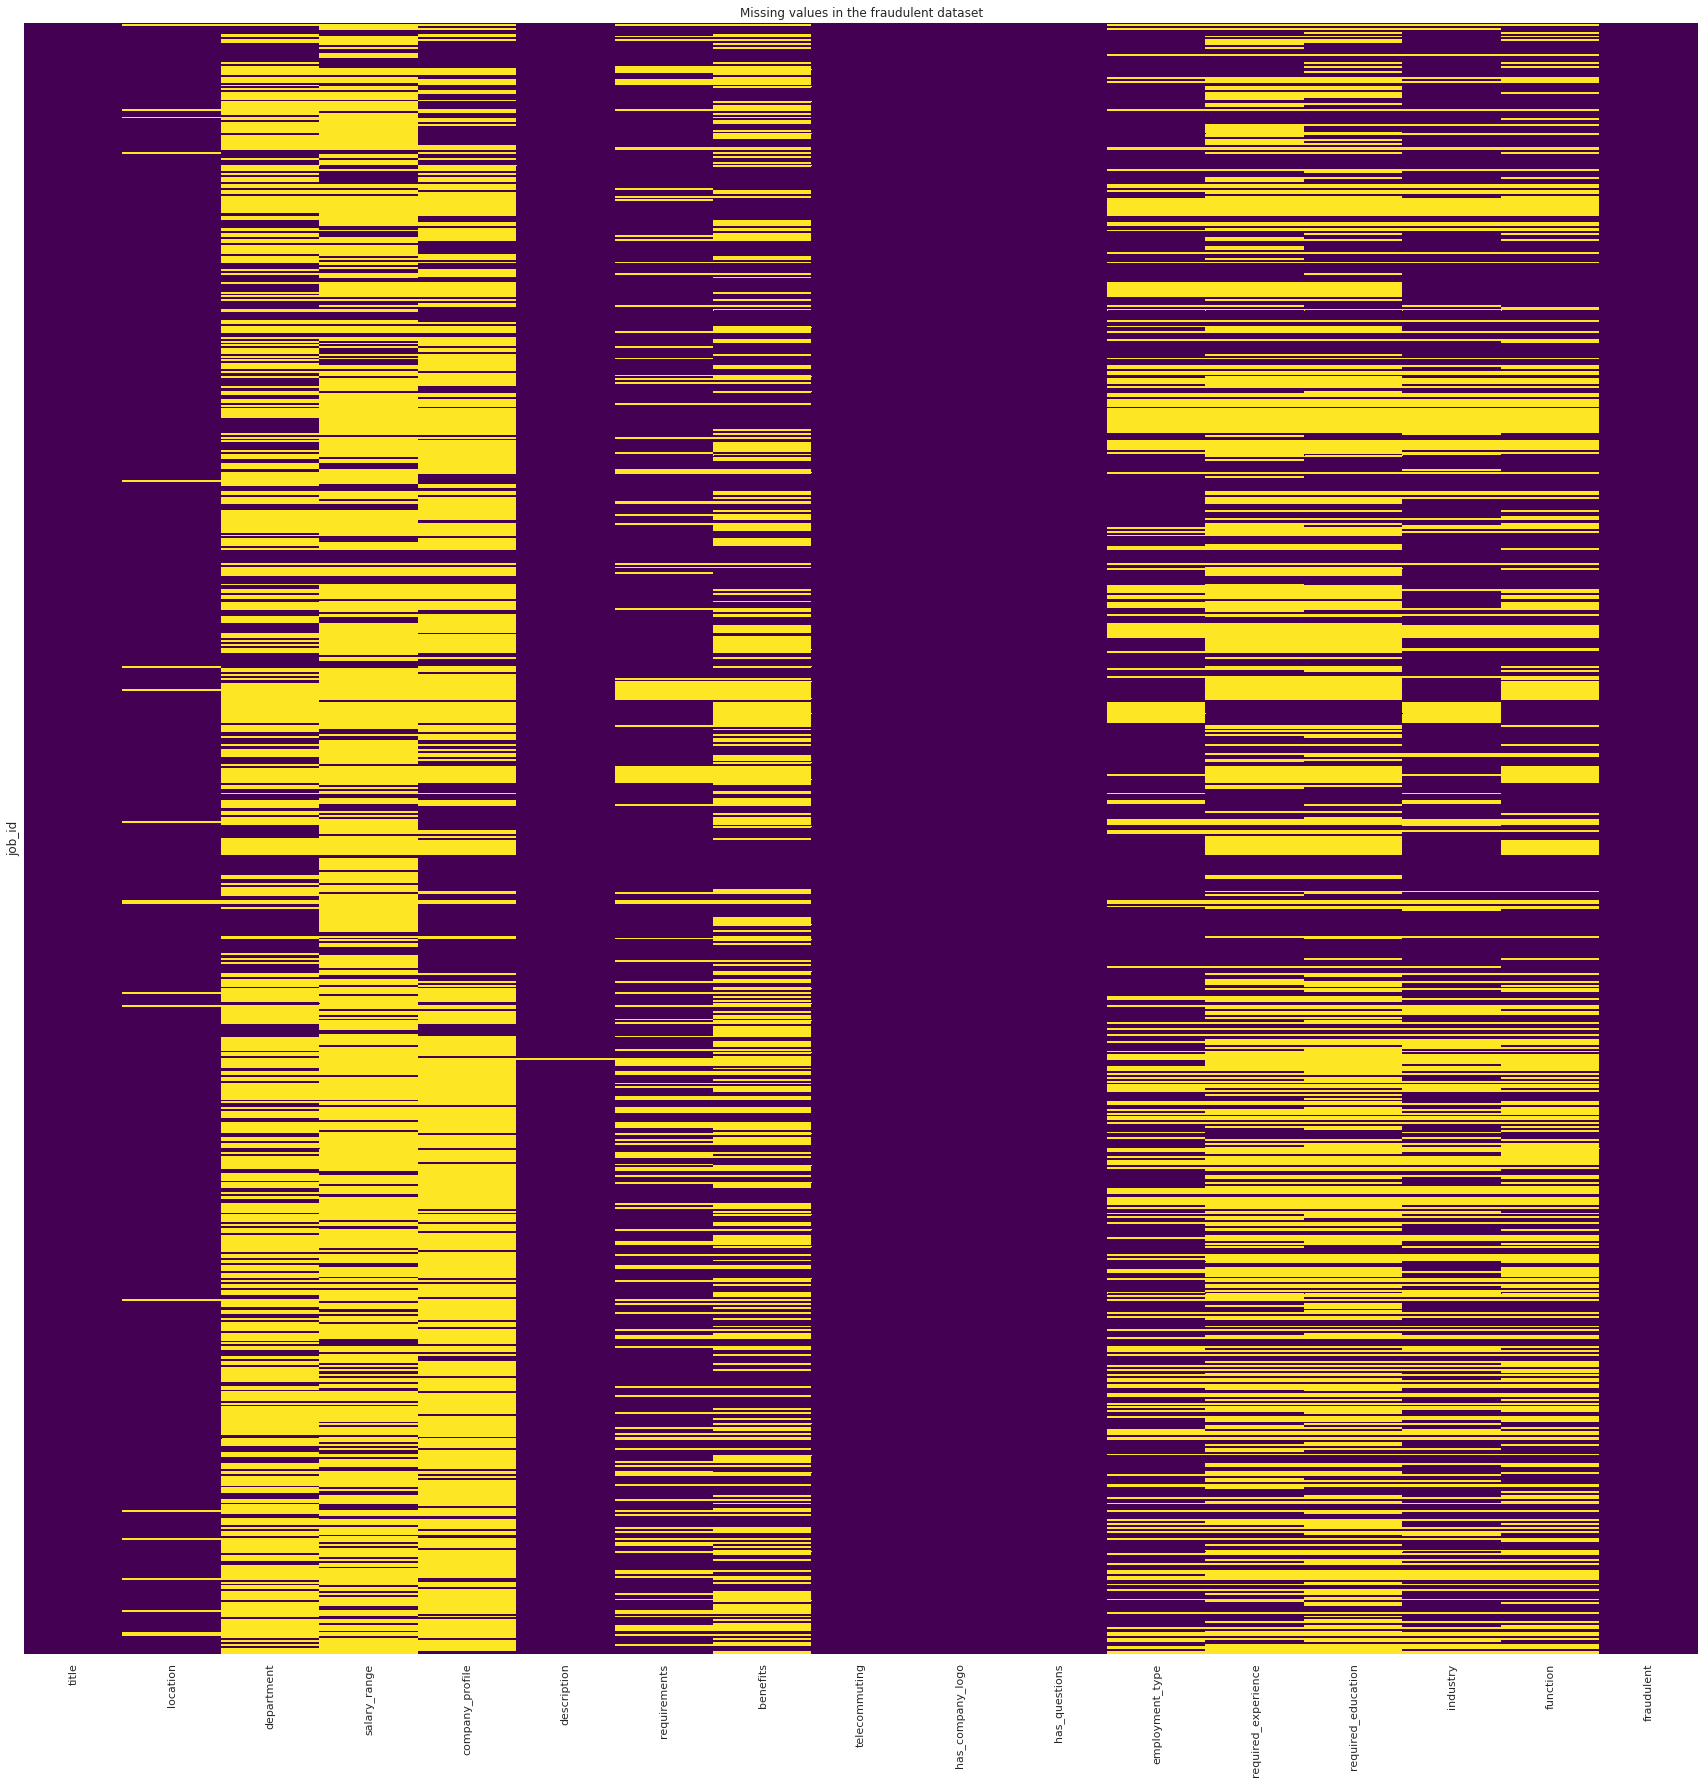

In [6]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar = False, cmap = 'viridis',);
plt.title('Missing values in the fraudulent dataset');

It seems like the fraudsters are struggling with the company profiles...

In [7]:
_na = pd.DataFrame(index=['HasValue','IsNA'])
for header in df.columns:
    _na[header] = df[header].isna().value_counts()[0]
_na.loc['IsNA'] = 17880 - _na.loc['HasValue']
_na = _na.T

In [8]:
_na

,HasValue,IsNA
title,17880,0
location,17534,346
department,6333,11547
salary_range,2868,15012
company_profile,14572,3308
description,17879,1
requirements,15185,2695
benefits,10670,7210
telecommuting,17880,0
has_company_logo,17880,0


In [9]:
df[df['department'].isna()==True]

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17872,Water Truck Driver,"US, PA, Waynesburg",NaN,NaN,Valor Services provides Workforce Solutions th...,Requires skilled work in operating commercial ...,GED or diploma required.Requires minimum of on...,NaN,0,1,1,Full-time,NaN,NaN,Oil & Energy,NaN,0
17874,Recruiting Coordinator,"US, NC, Charlotte",NaN,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,1,0,Contract,NaN,NaN,Utilities,NaN,0
17875,JavaScript Developer,"US, ,",NaN,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0


### Insights
This dataset contains 17880 jobs and a maximum of 16 characteristics are given to each jobs.
All jobs entry have manually been assigned a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers being flagged as legitimate whilst 866 have been flagged as fraudulent.
_Note:This assignment was done manually and errors might have occured._

The only job without a description (`df[df['description'].isna()==True]`) is a fraudulent post: Office manager in Warsaw, PL)

In [10]:
set(df['location'])

{nan,
 'US, WA, Bellingham',
 'IN, MH, mumbai',
 'US, TX, Allen',
 'GB, , West Bromwich',
 'US, OH, Richfield',
 'US, , Batavia',
 'US, AK, Juneau',
 'US, PA, Reading',
 'TT, , ',
 'GB, ESS, Colchester ',
 'GB, , Liverpool',
 'US, IL, Oak Brook',
 'US, NY, Manhattan and Brooklyn',
 'US, MI, 48226',
 'US, TX, Arlington',
 'US, , Newcastle',
 'US, KS, Overland park',
 'US, IN, Cayuga',
 'GB, ABE, Aberdeen',
 'US, IN, Cedar Rapids',
 'US, , West/Southwest Region',
 'US, TX, Round Rock',
 'SE, T, Lund',
 'VI, , Multiple',
 'US, FL, Fort Lauderdale',
 'KR, , Seoul',
 'US, CA, Los Angeles ',
 'US, NY, Bronx',
 'BE, VBR, Leuven',
 'SA, 01, ',
 'NZ, S, Nelson/Marlborough',
 'CA, AB, ',
 'US, CO, Minneapolis',
 'GB, NET, Gateshead',
 'CA, QC, ',
 'BG, 23, ',
 'US, MI, Brighton ',
 'HR, 21, ',
 'CL, RM, Santiago',
 "US, MO, Lee's Summit ",
 'US, OH, Seville',
 'GB, DBY, chesterfield',
 'GB, HEF, Hemel Hempstead',
 'GB, LND, London',
 'US, AL, Troy',
 'US, VA, Emporia',
 'US, MA, salisbury',
 'US

Location: remove `\t`, expect postcodes,'See the Requirements section for areas and locations available', greek characters, 'Silicon Valley/San Jose\xa0-\xa0Santa Clara', 'Work from home', accents (Quebec), multiple locations (Amsterdam, Rotterdam, The Hague, Utrecht)

Location needs to be consolidated (there a a couple of the same city with different county, etc.)

In [11]:
df[df['location']=='US, CA, BERKELY ']

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
5188,Sales - Sports Advertising Sales,"US, CA, BERKELY",SALES,NaN,Campus Concepts we are a National Sports Marke...,Sales- Sports Advertising - Closers Only Sport...,NaN,NaN,1,1,0,Full-time,Mid-Senior level,NaN,Marketing and Advertising,Sales,0


## Fraudulent Bag of Words

In [75]:
import nltk
import numpy as np
from nltk.tokenize import word_tokenize

In [16]:
def count_vector(document, vocab=None):
    if vocab:
        vocab = vocab
    else:
        vocab = list(set(document))
    
    document_dict = {i:0 for i in vocab}
    for word in document:
        document_dict[word] += 1
    return document_dict

In [26]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

In [ ]:
def bag_it(doc):
    bag = {}
    for word in doc.split():
        bag[word] = bag.get(word, 0) + 1
    return bag

In [43]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [13]:
dffraud['requirements'].index

Int64Index([   99,   145,   174,   181,   216,   358,   494,   538,   574,
              585,
            ...
            17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831,
            17832],
           dtype='int64', name='job_id', length=866)

In [66]:
document = dffraud['requirements'][99]
type(document)

str

In [69]:
tokenized_doc = word_tokenize(document)
type(tokenized_doc)

list

In [71]:
bOw_dict = count_vector(tokenized_doc)
type(bOw_dict)

dict

In [86]:
tf = term_frequency(bOw_dict)
type(tf)

113

In [77]:
idf = inverse_document_frequency(
    [count_vector(
        word_tokenize(
            str(document))) for i,document in enumerate(dffraud['requirements'])
    ]
)

In [88]:
len(idf)

7551

In [91]:
len([document for i,document in enumerate(dffraud['requirements'])])*len(tf)

97858

# TF-IDF function doesn't seem to work!

In [78]:
def tf_idf(list_of_dict):
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dict)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    tf_idf_list_of_dicts = []
    for document in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

In [81]:
tf_idf = inverse_document_frequency(
    [count_vector(
        word_tokenize(
            str(document))) for i,document in enumerate(dffraud['requirements'])
    ]
)

In [85]:
len(tf_idf)

7551